## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [94]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import io
from datasets import load_dataset
from torch.utils.data import random_split

In [108]:
dataset = load_dataset("food101")

Found cached dataset parquet (/Users/lidaharyton/.cache/huggingface/datasets/parquet/food101-a19b2e11bcb1e228/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [109]:
train_data = dataset['train'].select(range(2000))
val_data = dataset['validation'].select(range(1000))

<function matplotlib.pyplot.show(close=None, block=None)>

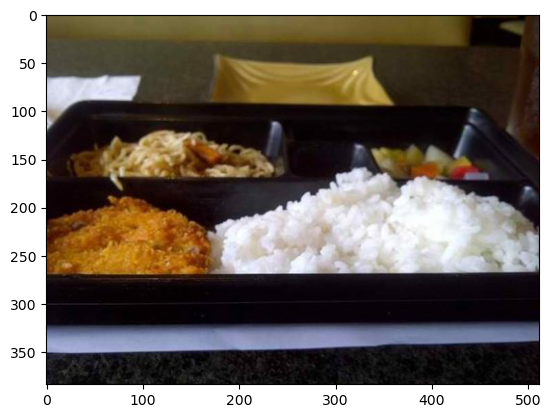

In [117]:
plt.imshow(train_data[1998]['image'])
plt.show

In [98]:
class FoodDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        sample = self.ds[idx]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [100]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [101]:
train_data = FoodDataset(train_data, transform=transform)
val_data = FoodDataset(val_data, transform=transform)

In [102]:
batch_size = 64

train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 1024)
        self.fc2 = nn.Linear(1024, 101) 
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(self.norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.norm2(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [104]:
device = torch.device("cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [105]:
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_data_loader)}")

Epoch 1, Loss: 26.45861430466175
Epoch 2, Loss: 3.492298498749733
Epoch 3, Loss: 0.7670535268262029
Epoch 4, Loss: 0.3057600809261203
Epoch 5, Loss: 0.2529034848557785
Epoch 6, Loss: 0.18656517378985882
Epoch 7, Loss: 0.030869588212226517
Epoch 8, Loss: 0.016967438470601337
Epoch 9, Loss: 0.02100810729098157
Epoch 10, Loss: 0.004635820734620211
Epoch 11, Loss: 0.002265704079036368
Epoch 12, Loss: 0.0015990205465641338
Epoch 13, Loss: 0.0010956801652355352
Epoch 14, Loss: 0.0008111101278700517
Epoch 15, Loss: 0.0006705590812998707
